# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
raw_train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
raw_test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(raw_train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(raw_test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# Explore the classes available in CIFAR10 dataset.
classes = raw_train.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Get the data distribution for all the classes in CIFAR10 dataset.
class_count = {}
for index in raw_train.targets:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
torch.Size([128, 3, 32, 32])
torch.Size([128])


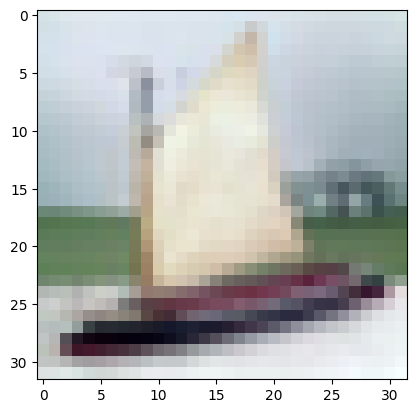

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = raw_train.data
# train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', raw_train.data.shape)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

show_image = images[0].numpy().transpose((1,2,0))
# Rescale the pixel values to [0, 1]
show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))

plt.imshow(show_image)


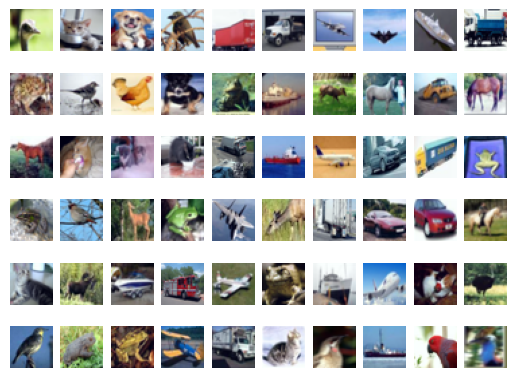

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    show_image = images[index].numpy().transpose((1,2,0))
    # Rescale the pixel values to [0, 1]
    show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))

    plt.imshow(show_image)

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((16, 30, 30)),
            nn.ReLU()
        ) # output_size = 30

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((16, 28, 28)),
            nn.ReLU()
        ) # output_size = 28

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.LayerNorm((16, 28, 28)),
            nn.ReLU()
        ) # output_size = 28

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((32, 12, 12)),
            nn.ReLU()
        ) # output_size = 12

        self.convblock5= nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((32, 10, 10)),
            nn.ReLU()
        ) # output_size = 10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.LayerNorm((32, 10, 10)),
            nn.ReLU()
        ) # output_size = 10

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 5

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((32, 3, 3)),
            nn.ReLU()
        ) # output_size = 3

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm((32, 1, 1)),
            nn.ReLU()
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.2)

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 4

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = x + self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = x + self.convblock6(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = x + self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
         LayerNorm-2           [-1, 16, 30, 30]          28,800
              ReLU-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 16, 28, 28]           2,304
         LayerNorm-5           [-1, 16, 28, 28]          25,088
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]             256
         LayerNorm-8           [-1, 16, 28, 28]          25,088
              ReLU-9           [-1, 16, 28, 28]               0
          Dropout-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 32, 12, 12]           4,608

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4761937856674194 Batch_id=390 Accuracy=34.13: 100%|██████████| 391/391 [00:25<00:00, 15.19it/s]



Test set: Average loss: 1.5145, Accuracy: 4484/10000 (44.84%)

EPOCH: 1


Loss=1.404650092124939 Batch_id=390 Accuracy=48.37: 100%|██████████| 391/391 [00:17<00:00, 22.56it/s]



Test set: Average loss: 1.3339, Accuracy: 5171/10000 (51.71%)

EPOCH: 2


Loss=1.2720396518707275 Batch_id=390 Accuracy=53.66: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]



Test set: Average loss: 1.2363, Accuracy: 5612/10000 (56.12%)

EPOCH: 3


Loss=1.319056749343872 Batch_id=390 Accuracy=57.15: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]



Test set: Average loss: 1.1455, Accuracy: 5920/10000 (59.20%)

EPOCH: 4


Loss=0.858198344707489 Batch_id=390 Accuracy=60.26: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]



Test set: Average loss: 1.0643, Accuracy: 6256/10000 (62.56%)

EPOCH: 5


Loss=0.9222108721733093 Batch_id=390 Accuracy=63.14: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 1.0346, Accuracy: 6372/10000 (63.72%)

EPOCH: 6


Loss=0.9170612096786499 Batch_id=390 Accuracy=68.09: 100%|██████████| 391/391 [00:17<00:00, 22.01it/s]



Test set: Average loss: 0.9313, Accuracy: 6781/10000 (67.81%)

EPOCH: 7


Loss=0.7185827493667603 Batch_id=390 Accuracy=69.02: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s]



Test set: Average loss: 0.9091, Accuracy: 6824/10000 (68.24%)

EPOCH: 8


Loss=0.9779458045959473 Batch_id=390 Accuracy=69.52: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s]



Test set: Average loss: 0.9092, Accuracy: 6814/10000 (68.14%)

EPOCH: 9


Loss=0.7879305481910706 Batch_id=390 Accuracy=69.88: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]



Test set: Average loss: 0.8961, Accuracy: 6857/10000 (68.57%)

EPOCH: 10


Loss=0.6313096284866333 Batch_id=390 Accuracy=70.20: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]



Test set: Average loss: 0.9191, Accuracy: 6760/10000 (67.60%)

EPOCH: 11


Loss=0.9076067209243774 Batch_id=390 Accuracy=70.64: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]



Test set: Average loss: 0.8975, Accuracy: 6875/10000 (68.75%)

EPOCH: 12


Loss=0.9868942499160767 Batch_id=390 Accuracy=71.43: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]



Test set: Average loss: 0.8845, Accuracy: 6896/10000 (68.96%)

EPOCH: 13


Loss=0.6686009764671326 Batch_id=390 Accuracy=71.60: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]



Test set: Average loss: 0.8805, Accuracy: 6914/10000 (69.14%)

EPOCH: 14


Loss=0.8123425245285034 Batch_id=390 Accuracy=71.69: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.8786, Accuracy: 6933/10000 (69.33%)

EPOCH: 15


Loss=1.020607352256775 Batch_id=390 Accuracy=71.69: 100%|██████████| 391/391 [00:17<00:00, 22.54it/s]



Test set: Average loss: 0.8836, Accuracy: 6902/10000 (69.02%)

EPOCH: 16


Loss=0.7429060339927673 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [00:18<00:00, 21.23it/s]



Test set: Average loss: 0.8795, Accuracy: 6925/10000 (69.25%)

EPOCH: 17


Loss=0.8590192794799805 Batch_id=390 Accuracy=71.78: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]



Test set: Average loss: 0.8804, Accuracy: 6909/10000 (69.09%)

EPOCH: 18


Loss=0.9036032557487488 Batch_id=390 Accuracy=71.91: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]



Test set: Average loss: 0.8782, Accuracy: 6940/10000 (69.40%)

EPOCH: 19


Loss=0.7409573197364807 Batch_id=390 Accuracy=71.75: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s]



Test set: Average loss: 0.8784, Accuracy: 6929/10000 (69.29%)



Text(0.5, 1.0, 'Test Accuracy')

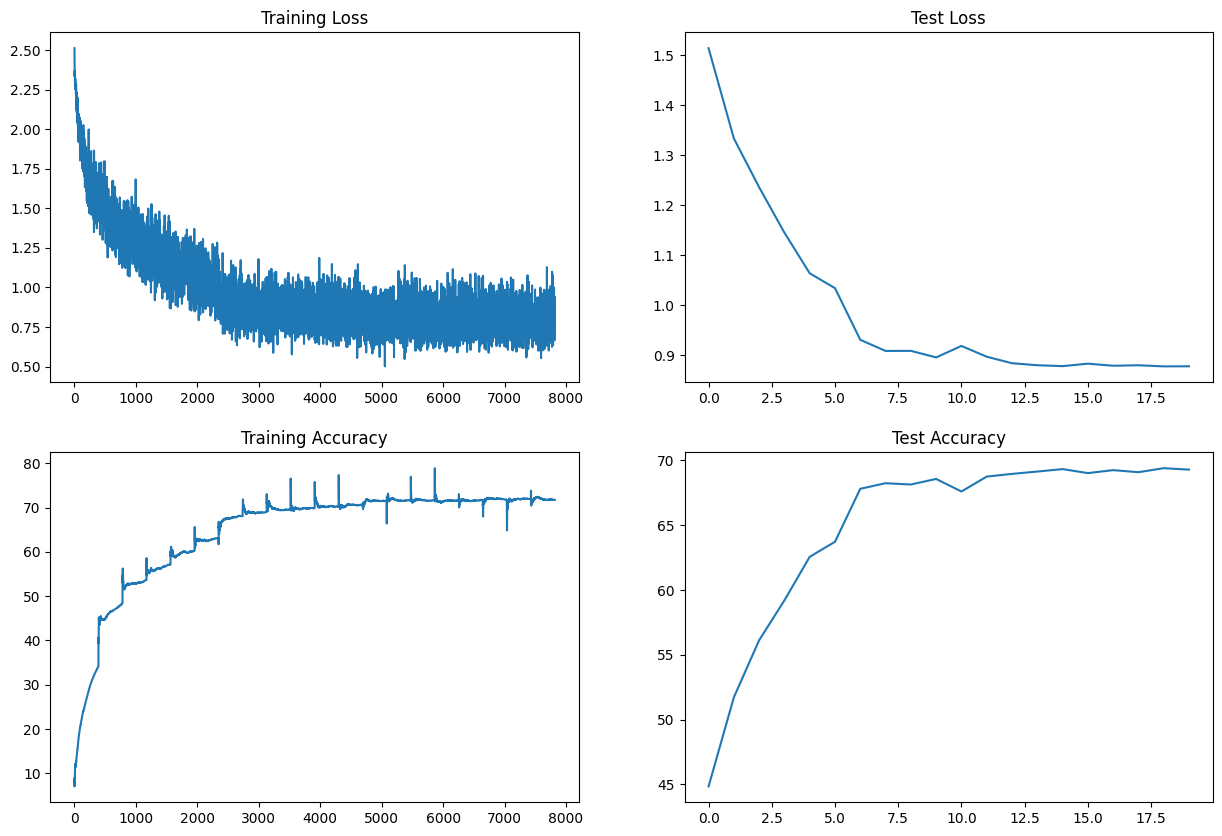

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import torch.nn.functional as F
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect


In [ ]:
incorrect = get_incorrrect_predictions(model, test_loader, device)

In [ ]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.keys())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        show_image = d.cpu().numpy().transpose(1, 2, 0)
        # Rescale the pixel values to [0, 1]
        show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))
        plt.imshow(show_image)
        if i+1 == 5*(count/5):
            break

Total Incorrect Predictions 3071


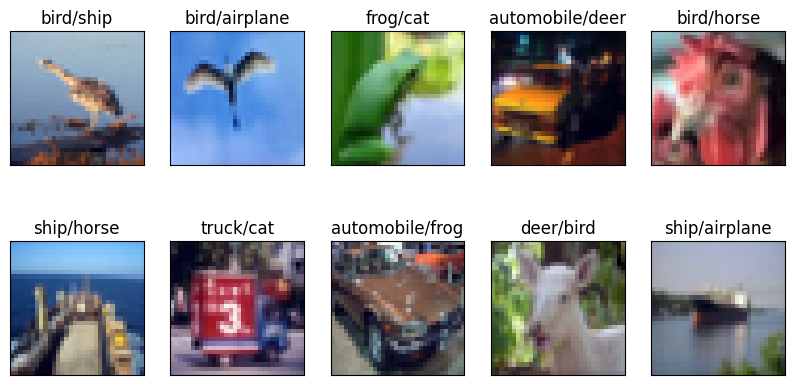

In [ ]:
plot_incorrect_predictions(incorrect, raw_test.class_to_idx)